# MNIST

MNIST数据集是一组由美国高中生和人口调查局员工手写的70 000个数字的照片，每张照片都有其代表的数字标记📌

可以直接从`Scikit-Learn`的`fetch_openml()`函数获取流行的公开数据集

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)

print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X = mnist.data       # 数据集
y = mnist.target     # 带标记的数组
X.shape, y.shape

((70000, 784), (70000,))

由此可知，共有7万张照片，每张照片上有784个特征。因为图像是28*28像素，每个特征代表了一个像素点，从0(白色)~255(黑色)。

- 绘制单个图像

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

In [6]:
def plot_one_image(pick_digit):
    one_digit = X[pick_digit]
    one_digit_img = one_digit.reshape((28,28))
    #  cm.binary--二值图/  cm.gray--灰度图

    fig, ax = plt.subplots(figsize = (1,1))
    ax.matshow(one_digit_img ,cmap=mpl.cm.binary)
    plt.axis("off")

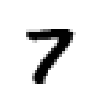

这是数字 7


In [7]:
pick_digit = np.random.randint(0,70000)

plot_one_image(pick_digit)
plt.show()
print("这是数字", y[pick_digit])

- 绘制n方个图像

In [8]:
def plot_N_image(n):
    pick_digits = np.random.choice(np.arange(X.shape[0]), np.power(n, 2))
    
    fig,ax = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(5,5))
    
    for i in range(n):
        for j in range(n):
            index = pick_digits[i*n+j]
            digit = X[index]
            digit_img = digit.reshape((28,28))
            ax[i,j].matshow(digit_img, cmap=mpl.cm.binary)
            
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


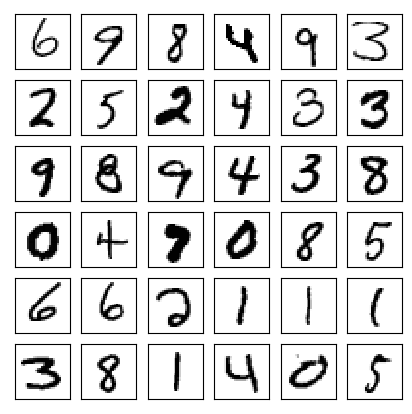

In [9]:
plot_N_image(n=6)
plt.show()

- 数据集初步处理

In [10]:
y = y.astype(np.uint8)   # 将标签类型由str转成整型

In [11]:
# MNIST训练集已经划分好了训练集和测试集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 训练二次分类器 Binary classifier

首先简化问题为"数字五的检测器"

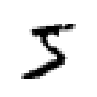

In [12]:
digit_5 = X[0]
plot_one_image(0)

In [13]:
# 创建目标向量 如果y==5 返回 True 否则返回 False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

- `Scikit-Learn`的`SGDClassifier()`函数实现随机梯度下降分类器

`随机梯度下降法(SGD)`不同于批量梯度下降，随机梯度下降是每次迭代使用一个样本来对参数进行更新。使得训练速度加快。

$$
\theta_{j}:=\theta_{j}+\alpha\left(y^{(i)}-h_{\theta}\left(x^{(i)}\right)\right) x_{j}^{(i)} 
$$

In [14]:
from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf_model  = SGDClassifier(random_state=42)
sgd_clf_model.fit(X=X_train, y=y_train_5)

SGDClassifier(random_state=42)

In [16]:
# 检测数字5的照片 
sgd_clf_model.predict([digit_5])

array([ True])

# 性能测量 Performance Measures

## 使用交叉验证测量准确率 Measuring Accuracy Using Cross-Validation

1.  `Scikit-Learn`的`StratifiedKFold()`函数实现K折交叉验证并适用分层抽样的形式 

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone    # 复制模型及其参数。属于深层复制

In [18]:
sklearn_split = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)  # 采用3-折交叉验证
# shuffle=True 实现数据混洗

In [19]:
for train_index, test_index in sklearn_split.split(X=X_train, y=y_train_5):
    clone_clf_model = clone(sgd_clf_model)   
    
    # 注意是将训练集进行K-折划分区块
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train_5[train_index], y_train_5[test_index]
    
    clone_clf_model.fit(X=X_train_fold, y=y_train_fold)
    y_predict = clone_clf_model.predict(X_test_fold)
    
    # 测试集中成功预测率
    correct = sum(y_predict == y_test_fold) # 验证正确
    print(correct/len(y_predict)*100) 

96.69
91.625
96.785


2. 利用`Scikit-Learn`中的`cross_val_score()`函数 进行交叉验证评分

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(
    estimator=sgd_clf_model,
    X=X_train,
    y=y_train_5,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
)

array([0.95035, 0.96035, 0.9604 ])

利用上述两种方法我们可以观察到准确率超过了95%，但是我们接下来研究下一种将每张图都分类成"非5"的分类器：

In [22]:
from sklearn.base import BaseEstimator

In [23]:
class Never_5_Classifier(BaseEstimator):

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((X.shape[0], 1), dtype=bool)
        # 预测值返回全为False

In [24]:
never_5_clf = Never_5_Classifier()

In [25]:
cross_val_score(estimator=never_5_clf,
                X=X_train,
                y=y_train_5,
                cv=3,
                scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

准确率超过90%。这是因为只有大约10%的图片是数字。

因此这些说明准确率通常无法成为分类器的首要性能指标。特别是当你处理有偏数据集的时候。

## 混淆矩阵 Confusion Matrix

评估分类器性能的更好方法是`混淆矩阵`，其总体思路就是统计A类别实例被分成B类别的次数

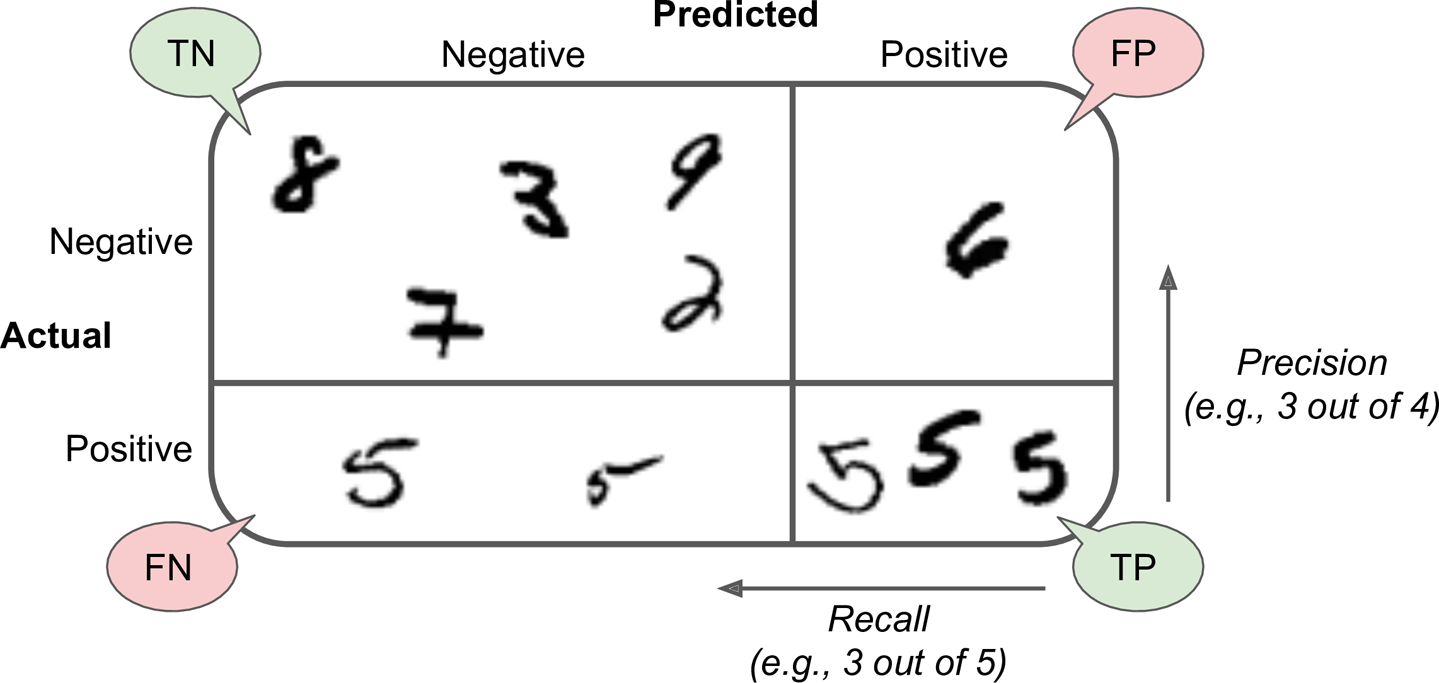

1. **正确肯定**（True Positive,TP）：预测为真，实际为真
2. **正确否定**（True Negative,TN）：预测为假，实际为假
3. **错误肯定**（False Positive,FP）：预测为真，实际为假
4. **错误否定**（False Negative,FN）：预测为假，实际为真

1. 首先获取一组预测才能将其与实际目标进行比较

`Scikit-Learn`的`cross_val_predict()`函数 进行K折交叉验证并返回每个预测结果

In [26]:
from sklearn.model_selection import cross_val_predict

In [27]:
y_train_prediction = cross_val_predict(
                        estimator=sgd_clf_model, 
                        X=X_train,
                        y=y_train_5,
                        cv=3,
                       )

In [28]:
y_train_prediction

array([ True, False, False, ...,  True, False, False])

2. 获取混淆矩阵

`Scikit-Learn`的`confusion_matrix()`函数 进行K折交叉验证并返回每个预测结果

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
confusion_matrix(y_pred=y_train_prediction,  # 预测类别
                 y_true=y_train_5)           # 目标类别

array([[53892,   687],
       [ 1891,  3530]])

所有正确的预测结果都在对角线上，所以从混淆矩阵中可以很方便直观的看出哪里有错误

In [31]:
confusion_matrix(y_pred=y_train_5, 
                 y_true=y_train_5)

array([[54579,     0],
       [    0,  5421]])

## 精度和召回率 Precision and Recall

- `查准率/精度/precision`
>$$precision=\frac{TP}{TP+FP}$$


- `召回率/查全率/recall`
>$$recall=\frac{TP}{TP+FN}$$


`Scikit-Learn`的`precision_score()`函数 获取评估指标-精度

`Scikit-Learn`的`recall_score()`函数 获取评估指标-召回率

In [32]:
from sklearn.metrics import precision_score, recall_score

In [33]:
precision_score(y_pred=y_train_prediction, y_true=y_train_5)
# 3530/(687+3530)

0.8370879772350012

In [34]:
recall_score(y_pred=y_train_prediction, y_true=y_train_5)
# 3530/(1891+3530)

0.6511713705958311

只有83.7%的概率是准确的。并且只有65.1%的数字5，被检测出来了。因此模型的表现对比准确率就不是特别优秀

我们可以很方便的将精度和召回率组合成一个单一的指标，被称为$F_1$分数

>$$
F_{1}=\frac{2}{\frac{1}{\text { precision }}+\frac{1}{\text { recall }}}=2 \times \frac{\text { precision } \times \text { recall }}{\text { precision }+\text { recall }}=\frac{T P}{T P+\frac{F N+F P}{2}}
$$

`Scikit-Learn`的`f1_score()`函数 获取评估指标-$F_1$分数

In [35]:
from sklearn.metrics import f1_score

In [36]:
f1_score(y_pred=y_train_prediction, y_true=y_train_5)

0.7325171197343846

$F_1$分数对那些具有相近精度和召回率的回归其更有利。

## 精度/召回率权衡 Precision/Recall Trade-off

### 阈值与精度/召回率的关系

随着精度的增加，召回率会降低；召回率增加，精度就会降低。因此我们考虑`精度/召回率权衡`

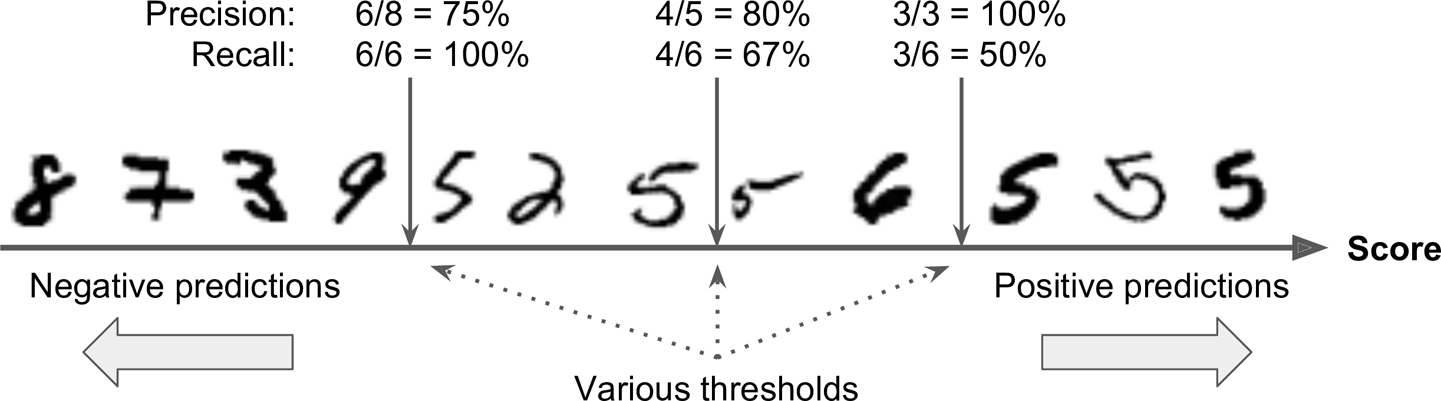

图像按照其分类器评分进行排名，而高于所选决策阈值的图像被认为是正的；阈值越高，召回率越低，但通常精度越高。

`Scikit-Learn`不允许直接设置阈值，但可以访问它用于预测的决策分数。

`decision_function()`方法返回的是每个实例的分数 从而根据这些分数使用阈值进行预测

In [37]:
y_5_scores = sgd_clf_model.decision_function([digit_5])   # digit_5 = X[0]
y_5_scores

array([2164.22030239])

- 阈值设为0时：

In [38]:
threshold = 0 

In [39]:
y_5_prediction = (y_5_scores > threshold)
y_5_prediction

array([ True])

- 阈值设为8000时：

In [40]:
threshold = 8000

In [41]:
y_5_prediction = (y_5_scores > threshold)
y_5_prediction

array([False])

由此可见，提升阈值确实可以降低召回率

### 确定阈值

1. 首先`cross_val_predict()`函数 获取所有实例的分数

In [42]:
from sklearn.model_selection import cross_val_predict

In [43]:
y_scores = cross_val_predict(estimator=sgd_clf_model, 
                             X=X_train,
                             y=y_train_5,
                             cv=3,
                             method="decision_function",   # 返回决策分数而不是预测结果
                             n_jobs=-1,
                            )

In [44]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

2. `Scikit-Learn`的`precision_recall_curve()`函数 计算所有可能的阈值的精度和召回率。

In [45]:
from sklearn.metrics import precision_recall_curve

In [46]:
precisions, recalls, thresholds = precision_recall_curve(
                                    y_true=y_train_5, 
                                    probas_pred=y_scores)       # 正类的预测概率或决策函数

In [47]:
precisions, recalls, thresholds

(array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
          38871.26391927,   42216.05562787,   49441.43765905]))

3. 绘制`精度/召回率对于阈值`函数图

In [48]:
# 使用中文字体
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='../Fonts/SourceHanSerifSC-Medium.otf', size=12)

In [49]:
def plot_PR_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 4))
    
    plt.plot(thresholds, precisions[:-1], 'b--', label="精度")
    plt.plot(thresholds, recalls[:-1], 'g-', label="召回率")
    
    
    plt.xlabel("阈值", fontproperties=my_font)
    plt.legend(prop = my_font)   # 图例使用中文 ：prop = my_font
    plt.axis([-50000, 50000, 0, 1])  
    plt.grid(True)
    
    plt.show()

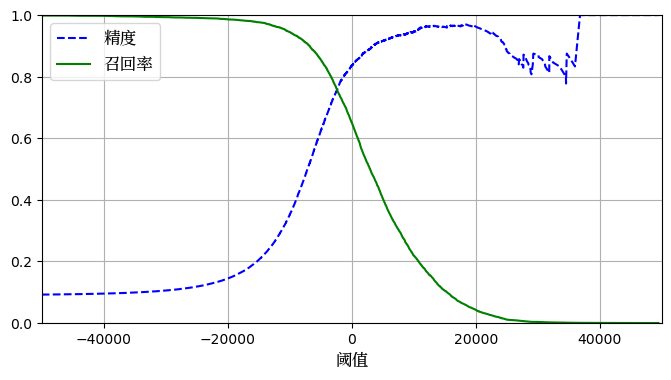

In [50]:
plot_PR_threshold(precisions, recalls, thresholds)

### 绘制PR曲线

In [51]:
def plot_PR(precisions, recalls, thresholds):
    plt.figure(figsize=(8,6))
    
    plt.plot(recalls, precisions, "b-", linewidth=2)
    
    plt.xlabel("召回率", fontproperties=my_font)
    plt.ylabel("精度", fontproperties=my_font)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
    plt.show()

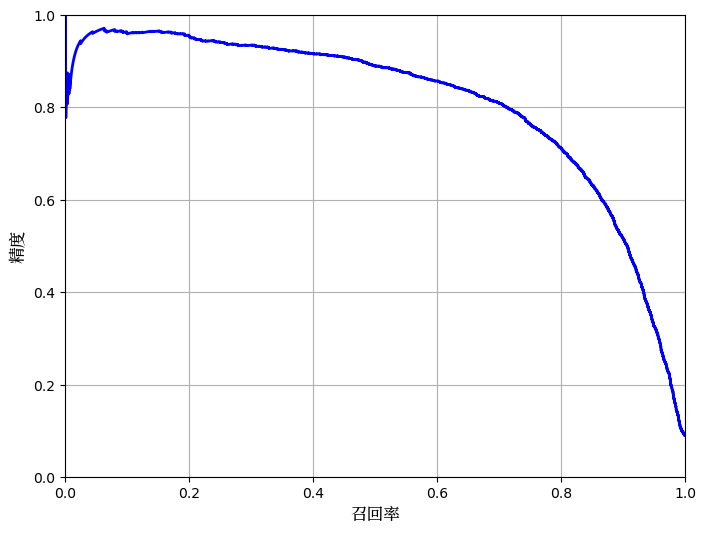

In [52]:
plot_PR(precisions, recalls, thresholds)

-  测试 假设精度设置到90%

In [53]:
# 1. 获取阈值
threshold_90 = thresholds[np.argmax(precisions >= 0.90)]   #  np.argmax() 用于返回一个数组中最大值的索引值。 
threshold_90

3370.0194991439557

In [54]:
# 2. 设置阈值 并进行预测
threshold = threshold_90

In [55]:
y_train_prediction_90 = (y_scores >= threshold)  
y_train_prediction_90

array([False, False, False, ...,  True, False, False])

In [56]:
# 3. 计算精度和召回率
precision_score(y_pred=y_train_prediction_90, y_true=y_train_5)

0.9000345901072293

In [57]:
recall_score(y_pred=y_train_prediction_90, y_true=y_train_5)

0.4799852425751706

## 受试者工作特征曲线 The ROC Curve

该曲线的横坐标为`假正类率（False Positive Rate, FPR）`
纵坐标为`真正类率（True Positive Rate, TPR）`

即，横、纵坐标算的都是预测正类占实际本身假、真的比率。

- `召回率/真正类率/TPR`
>$$TPR=\frac{TP}{TP+FN}$$

- `假正类率/FPR`
>$$FPR=\frac{FP}{TN+FP}=1-TNR$$

- `真负类率/TNR/特异度`
>$$TNR=\frac{TN}{TN+FP}$$

`Scikit-Learn`的`roc_curve()`函数 计算计算多重阈值的`TPR`和`FPR`

In [58]:
from sklearn.metrics import roc_curve

In [59]:
FPR, TPR, threshold = roc_curve(y_true=y_train_5, y_score=y_scores)

- 绘制`ROC`曲线

In [60]:
def plot_roc(FPR, TPR, label):
    plt.plot(FPR, TPR, linewidth=2, label=label)
    plt.plot([0, 1],[0, 1], 'k--')  
    
    plt.xlabel("假正类率", fontproperties=my_font)
    plt.ylabel("真正类率", fontproperties=my_font)
    plt.axis([0, 1, 0, 1])
    plt.legend(prop=my_font)
    plt.grid(True)

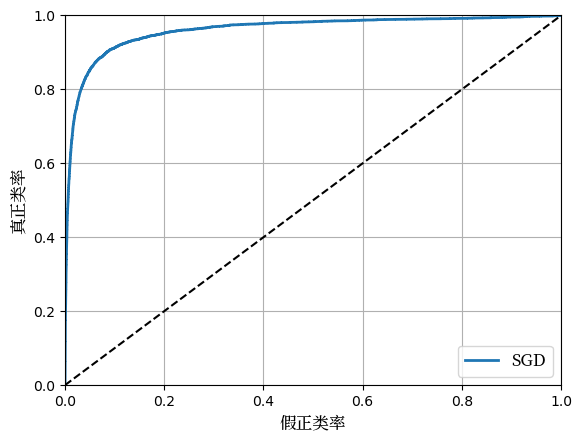

In [61]:
plot_roc(FPR, TPR, "SGD")
plt.show()

1. 该曲线绘制了所有可能的阈值的假正类率和真正类率的关系。

2. 虚线表示纯随机分类器的ROC曲线，一个优秀的分类器应该离这条线越远越好。

- ROC曲线下方的面积大小 The AUC Curve

`AUC`被定义为ROC曲线下与坐标轴围成的面积，显然这个面积的数值不会大于1。又由于ROC曲线一般都处于y=x这条直线的上方，所以AUC的取值范围在0.5和1之间。AUC越接近1.0，检测方法真实性越高;等于0.5时，则真实性最低，无应用价值。

`Scikit-Learn`的`roc_auc_score()`函数 计算计算`AUC`函数

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
roc_auc_score(y_true=y_train_5, y_score=y_scores)

0.9604938554008616

>ROC曲线和PR曲线的选择法则:当**正类非常少见**，或者你**更关注假正类**而非假负类的时，应该选择`PR曲线`，反之则是`ROC曲线`。

接下来，我们训练随机森林分类器，并比较它与随机梯度下降分类器的`ROC曲线`和`AUC分数`

- 利用`Scikit-Learn`的`RandomForestClassifier()`函数实现随机森林分类

In [64]:
from sklearn.ensemble import RandomForestClassifier

`predict_proba()`返回一个数组，其中每行代表一个实例，每列代表一个类别，意思是每个给定实例属于某一个给定类别的概率。

In [65]:
forest_clf_model = RandomForestClassifier(random_state=42, n_estimators=100)
forest_clf_prediction_proba = cross_val_predict(
                                estimator=forest_clf_model, 
                                X=X_train,
                                y=y_train_5,
                                cv=3,
                                method="predict_proba",
                                n_jobs=-1,
                               )

In [66]:
forest_clf_prediction_proba   # 第1列是取0的概率， 第2列是取1的概率

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

由于不提供分数，而是提供类概率，我们直接使用正类的概率作为分数值。

In [67]:
forest_clf_scores = forest_clf_prediction_proba[:,1]   # 取第2列

In [68]:
FPR_forest, TPR_forest, threshold_forest = roc_curve(y_true=y_train_5, y_score=forest_clf_scores)

- 比较ROC

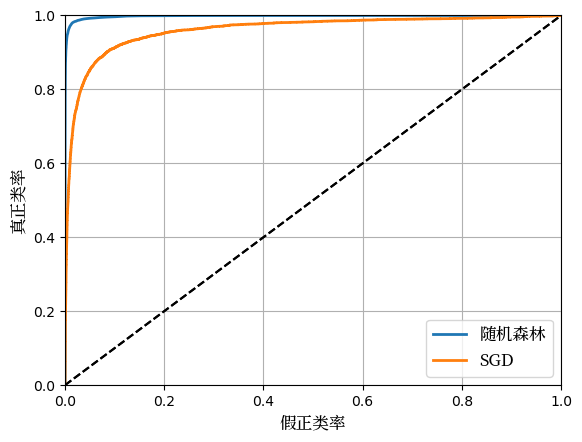

In [69]:
plot_roc(FPR_forest, TPR_forest, label="随机森林") # 随机森林的ROC曲线
plot_roc(FPR, TPR, label="SGD")   # SGD的ROC曲线              
plt.show()

- 比较AUC

In [70]:
roc_auc_score(y_true=y_train_5, y_score=forest_clf_scores)   # 随机森林的AUC

0.9983436731328145

In [71]:
roc_auc_score(y_true=y_train_5, y_score=y_scores)            # SGD的AUC

0.9604938554008616

随机森林分类器明显优于SGD分类器，因为它的ROC曲线更靠近左上角，并且具有更大的AUC

- 比较精度/召回率

In [72]:
forest_clf_prediction = cross_val_predict(
                                estimator=forest_clf_model, 
                                X=X_train,
                                y=y_train_5,
                                cv=3,
                                n_jobs=-1,
                                #method="predict_proba"
                               )

In [73]:
precision_score(y_pred=forest_clf_prediction, y_true=y_train_5)*100   # 精度

99.0508331575617

In [74]:
recall_score(y_pred=forest_clf_prediction, y_true=y_train_5)*100      # 召回率

86.62608374838591

# 多类分类器 Multiclass classification

- `一对多（OVR）`：训练时依次把某个类别的样本归为一类,其他剩余的样本归为另一类。这样k个类别的样本就构造出了k个二元分类器。分类时将 未知样本 分类为 具有最大分类函数值的那类。
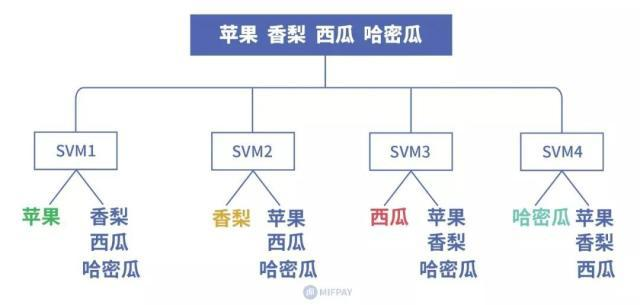

- `一对一（OVO）`：其做法是在任意两类样本之间设计一个二元分类器，因此k个类别的样本就要设计$\frac{k(k-1)}{2}$个二元分类器。在MNIST数据集中，意味着要训练45个二元分类器。当对一个 未知样本 进行分类时，最后得票最多的类别 即为 该未知样本的类别。
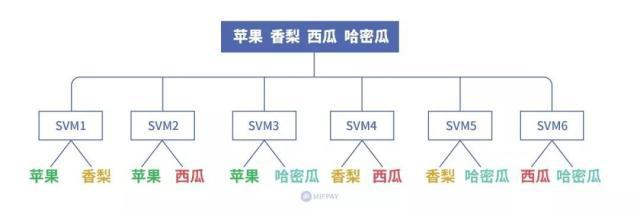

`支持向量机分类器(SVM)`在数据规模扩大时表现糟糕，优先采用`一对一`策略。但大多数二元分类器中，`一对多`策略比较适用。

`Scikit-Learn`可以自动检测到你尝试适用的二元分类算法进行多类分类任务，它会根据情况自动选择`一对多`或`一对一`策略

## 使用SVM分类器

 利用`Scikit-Learn`的`SVC()`函数支持向量机用于分类

In [75]:
from sklearn.svm import SVC

In [76]:
# 简化问题规模
SVM_X_train = X_train[:1000]
SVM_y_train = y_train[:1000]

In [77]:
svm_clf_model = SVC(random_state=42, gamma="auto")
svm_clf_model.fit(SVM_X_train, SVM_y_train)
svm_clf_model.predict([digit_5])

array([5], dtype=uint8)

在`Scikit-Learn`内部实际上要训练45个二元分类器,获取它们对图片的决策分数，然后选择了分数最高的类。

`decision_function()`方法返回每个类的分数

In [78]:
svm_5_digit_scores = svm_clf_model.decision_function([digit_5])
svm_5_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [79]:
np.argmax(svm_5_digit_scores)

5

In [80]:
svm_clf_model.classes_, svm_clf_model.classes_[5]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), 5)

最高分确实是5这个类别。本例中索引碰巧对应类本身，这一点需要注意

如果需要强制使用`一对多`或`一对一`策略：

- `Scikit-Learn`的`OneVsOneClassifier()`函数 一对一策略的多类分类

- `Scikit-Learn`的`OneVsRestClassifier()`函数 一对多策略的多类分类

In [81]:
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier

In [82]:
# 采用一对多策略，基于SVC的多类分类器
OVR_clf = OneVsRestClassifier(estimator=svm_clf_model)
OVR_clf.fit(SVM_X_train, SVM_y_train)
OVR_clf.predict([digit_5])

array([5], dtype=uint8)

## 使用SDG分类器

 `Scikit-Learn`的`SGDClassifier()`函数实现随机梯度下降分类器

In [83]:
sgd_clf_model  = SGDClassifier(random_state=42)
sgd_clf_model.fit(X=X_train, y=y_train)

SGDClassifier(random_state=42)

In [84]:
sgd_clf_model.predict([digit_5])

array([3], dtype=uint8)

SGD分类器直接可以将实例分为多个类。查看每个实例分类为每个类的概率列表:

In [85]:
sgd_clf_5_digit_scores = sgd_clf_model.decision_function([digit_5])
sgd_clf_5_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [86]:
sgd_clf_model.classes_[np.argmax(sgd_clf_5_digit_scores)]

3

使用交叉验证评估SDG分类器

In [87]:
cross_val_score(estimator=sgd_clf_model, 
                X=X_train, 
                y=y_train,
                cv=3,
                scoring="accuracy",
                
                n_jobs=-1,
                verbose=1,
               )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


array([0.87365, 0.85835, 0.8689 ])

仍有进一步提升的空间，如将输入进行简单的缩放

`Scikit-Learn`的`StandardScaler`类实现数据标准化

In [88]:
from sklearn.preprocessing import StandardScaler

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [90]:
cross_val_score(estimator=sgd_clf_model, 
                X=X_train_scaled,   # 实现缩放后的输入
                y=y_train,
                cv=3,
                scoring="accuracy",
                
                n_jobs=-1,
                verbose=1,
               )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.1min finished


array([0.8983, 0.891 , 0.9018])

# 误差分析 Error analysis

假设已经遵循`机器学习项目清单`的步骤，找到了一个有潜力的模型，现在你希望找到一些方法对其进行改进，方法之一就是分析其错误类型。

- 查看混淆矩阵

In [91]:
y_train_prediction = cross_val_predict(
                        estimator=sgd_clf_model, 
                        X=X_train_scaled,
                        y=y_train,
                        cv=3,
                        n_jobs=-1
                       )

In [92]:
conf_mx = confusion_matrix(y_true=y_train, y_pred=y_train_prediction)

In [93]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

- 混淆矩阵可视化

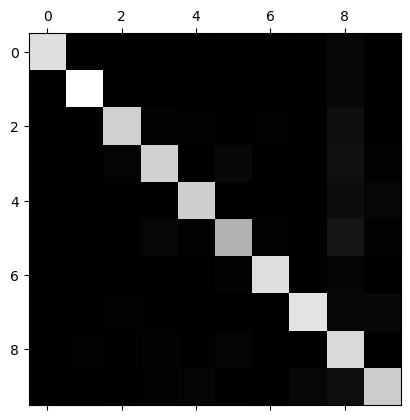

In [94]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

    大多数的图片都在主对角线上，说明他们被正确分类。

    但我们观察到数字5稍微的暗一点，我们需要去验证两种可能性：
    1.  数据集中，数字5的照片较少。
    2.  分类器在数字5的执行效果不如其他数字好。

-  产生错误的种类
    
    首先，你需要将 混淆矩阵中的每个值 除以 相应类中图片数量，这样也比较的就`错误率`，而不是错误的绝对值。因为后者对图片数量较多的类不公平。

In [95]:
row_sums = conf_mx.sum(axis=1, keepdims=True)   # keepdims=True 保持矩阵的二维特性
norm_conf_mx = conf_mx / row_sums

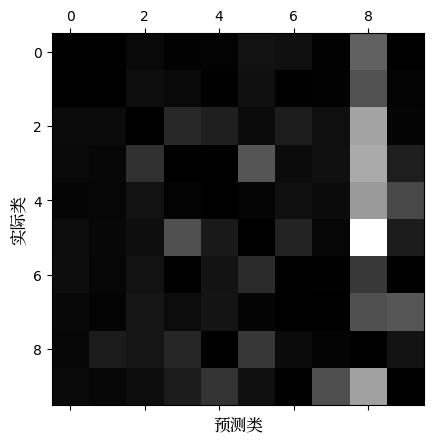

In [96]:
np.fill_diagonal(norm_conf_mx, 0)   # 用0填充对角线,只保留错误
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("预测类", fontproperties=my_font)
plt.ylabel("实际类", fontproperties=my_font)
plt.show()

现在可以清晰的看到分类器产生的错误种类。

可以观察到第8列看起来非常亮，说明有许多图片被错误的分类为数字8；然而第8行并不那么差：实际数字8，被正确分类为数字8.**分析混淆矩阵通常可以帮助你深入了解如何改进分类器**。通过上图来看，你的精力可以花在改进数字8的分类错误上。

1. 收集更多像数字8的训练数据
2. 开发一些新特征来改进分类器
3. 对图片进行预处理，要某些模式更加突出。比如闭环。

- 分析单个错误 以数字3，5为例
    
    可以观察到，数字3和数字5经常被混淆

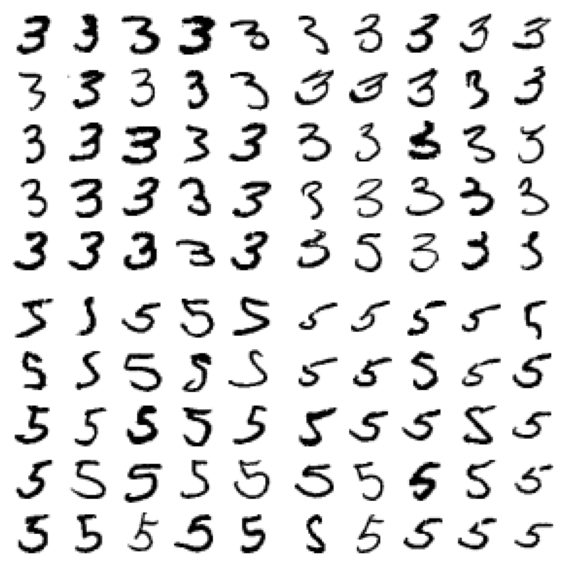

使用SGD模型，所要做的就是为 每像素 分配一个 各个类别的权重，当他看到新的图像时，将加权后的像素强度汇总，从而得到一个分数进行分类。而数字3和数字5只在一部分像素位上有区别，因此分类器很容易将其弄混。

因此，减少数字3和数字5混淆的方法之一，就是对图片进行预处理，确保它们位于中心位置，并没有旋转。

# 多标签分类 Multilabel classification

在某些情况下，你希望分类器为每个实例输出多个类。

- `Scikit-Learn`的`KNeighborsClassifier()`函数 实现K近邻分类算法(支持多标签分类)

In [97]:
from sklearn.neighbors import KNeighborsClassifier

In [98]:
y_train_large = (y_train >= 7)    # 大数类（7，8，9）
y_train_odd = (y_train%2 == 1)    # 奇数类

In [99]:
# np.r_:按列连接两个矩阵   np.c_:按行连接两个矩阵
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [100]:
knn_clf_model = KNeighborsClassifier()
knn_clf_model.fit(X_train, y_multilabel)   # 使用多个数组对KNN模型进行训练

KNeighborsClassifier()

In [101]:
knn_clf_model.predict([digit_5])

array([[False,  True]])

输出两个值，数字5(非小数,奇数) 预测正确

- 评估多标签分类的方法：


`Scikit-Learn`的`f1_score()`函数 获取评估指标-$F_1$分数

In [102]:
knn_train_prediction = cross_val_predict(
                        estimator=knn_clf_model, 
                        X=X_train,
                        y=y_multilabel,
                        cv=3,
    
                        n_jobs=-1,
                        verbose=2
                       )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.7s finished


In [103]:
f1_score(y_true=y_multilabel, y_pred=knn_train_prediction, average="macro")  # 宏平均

0.976410265560605

0.976410265560605

`宏平均macro`和`微平均micro`的对比:
1. 如果每个class的样本数量差不多,那么宏平均和微平均没有太大差异
2. 如果每个class的样本数量差异很大,而且你想:
    - 更注重样本量多的class:使用微平均
    - 更注重样本量少的class:使用宏平均
3. 如果微平均大大低于宏平均,检查样本量多的class
4. 如果宏平均大大低于微平均,检查样本量少的class

如果想给每个标签设置一个等于其自身支持的权重，可将代码设置为`average="weighted"`

# 多输出分类 Multioutput classification

`多输出-多类分类`:它是多标签分类的泛化，其标签也可以是多类的。

以移除图片中的噪点的系统为例：输入一张噪点图片，然后输出一张干净的图片，以像素强度的像素点矩阵表示。需要注意的是，这个分类器输出的是多个标签（每个像素点一个类别），并且每个标签可以有多个值（像素点的像素强度从0到255）.

In [104]:
# 添加噪声
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))

In [105]:
# 有噪声
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test

# 无噪声
y_train_mod = X_train 
y_test_mod = X_test

In [106]:
def plot_one_image_plus(pick_digit):
    one_digit = pick_digit
    one_digit_img = one_digit.reshape((28,28))
    fig, ax = plt.subplots(figsize = (1,1))
    ax.matshow(one_digit_img ,cmap=mpl.cm.binary)

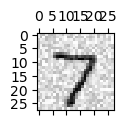

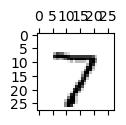

In [107]:
plot_one_image_plus(X_test_mod[0])
plot_one_image_plus(y_test_mod[0])
plt.show()

现在通过训练分类器清洗上面这张照片

In [108]:
knn_clf_model = KNeighborsClassifier()
knn_clf_model.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

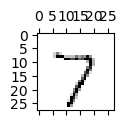

In [109]:
clean_digit = knn_clf_model.predict([X_test_mod[0]])
plot_one_image_plus(clean_digit)
plt.show()

# 练习题 Exercise

## ex. 1

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
 on the test set. Hint: the KNeighborsClassifier works quite well for this task;
 you just need to find good hyperparameter values (try a grid search on the
 weights and n_neighbors hyperparameters).

- 利用网格搜索微调模型

In [110]:
from sklearn.model_selection import GridSearchCV

In [111]:
param_grid = [
    {
        'weights':["uniform", "distance"],
        'n_neighbors':[3, 4, 5]
    }
]
# 尝试 6(2*3) 种超参数组合

In [112]:
knn_clf_model = KNeighborsClassifier()
grad_search = GridSearchCV(estimator=knn_clf_model, 
                           param_grid=param_grid,
                           cv=5,
                           
                           verbose=2,  # verbose：日志冗长度
                           n_jobs=-1   # 表示占用所有cpu开线程
                          )
grad_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=2)

In [113]:
# 获取最佳的参数组合：
grad_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [114]:
# 获取最佳的分数：  (neg_mean_squared_error)
grad_search.best_score_   

0.9716166666666666

In [115]:
# 获取模型分类准确率分数
from sklearn.metrics import accuracy_score

y_pred = grad_search.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.9714

## ex. 2

Write a function that can shift an MNIST image in any direction (left, right, up,
 or down) by one pixel.5 Then, for each image in the training set, create four shif‐
 ted copies (one per direction) and add them to the training set. Finally, train your
 best model on this expanded training set and measure its accuracy on the test set.
 You should observe that your model performs even better now! This technique of
 artificially growing the training set is called data augmentation or training set
 expansion.

- 实现图片在任意方向上的移动像素的功能

In [116]:
from scipy.ndimage.interpolation import shift

In [117]:
def shift_image(image,x,y):
    image = image.reshape((28,28))
    shifted = shift(input=image, shift=[y,x], cval=0, mode='constant')
    return shifted.reshape([-1])

In [118]:
# 测试 
shifted_image_down = shift_image(digit_5, 0, 5)  # 向下移动5个像素
shifted_image_left = shift_image(digit_5, -5, 0)  # 向左移动5个像素

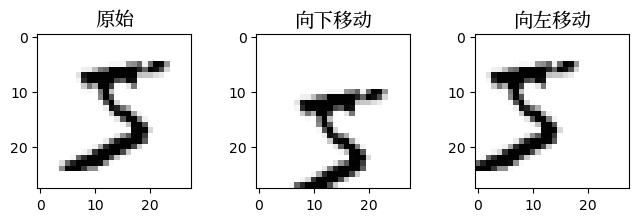

In [119]:
plt.figure(figsize=(8,2))

plt.subplot(131)
plt.title("原始", fontsize=14, fontproperties=my_font)
plt.imshow(digit_5.reshape(28, 28), cmap="Greys")

plt.subplot(132)
plt.title("向下移动", fontsize=14, fontproperties=my_font)
plt.imshow(shifted_image_down.reshape(28, 28), cmap="Greys")

plt.subplot(133)
plt.title("向左移动", fontsize=14, fontproperties=my_font)
plt.imshow(shifted_image_left.reshape(28, 28), cmap="Greys")

plt.show()

- 生成拓展训练集

In [120]:
# 展平训练集
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

In [121]:
# 拓展训练集
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [122]:
# 转换训练集
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

- 数据混洗

In [123]:
shuffle_index = np.random.permutation(len(X_train_augmented))   # 生成随机排列序列
X_train_augmented = X_train_augmented[shuffle_index]
y_train_augmented = y_train_augmented[shuffle_index]

- 训练模型

In [124]:
knn_clf_model = KNeighborsClassifier(**grad_search.best_params_)  # 使用微调模型后的最佳超参数
#knn_clf_model = KNeighborsClassifier(n_jobs=-1)

In [125]:
knn_clf_model.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [126]:
knn_clf_prediction = knn_clf_model.predict(X_test)
accuracy_score(y_true=y_test, y_pred=knn_clf_prediction)

0.9763

通过简单地增强数据，我们的精度提高0.5％。

## ex. 3

Tackle the Titanic dataset. A great place to start is on Kaggle. The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

详见`ex.3 Tiranic`

First, login to [Kaggle](https://www.kaggle.com/) and go to the [Titanic challenge](https://www.kaggle.com/c/titanic) to download `train.csv` and `test.csv`. Save them to the `datasets/titanic` directory.

###  获取数据

In [127]:
import os
import pandas as pd

In [128]:
def load_titanic_data(path, filename):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

In [131]:
titanic_path = os.path.join("../datasets/", "titanic")

In [132]:
train_data = load_titanic_data(path=titanic_path, filename="train.csv")
test_data = load_titanic_data(path=titanic_path, filename="test.csv")

数据已被分成训练集和测试集。但是，测试数据中不包含标签：目标是在训练集上训练可以使用的最佳模型，然后在测试集上进行预测并求出最终得分。 

1. 展示前五行数据

In [133]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


该属性具有以下含义： 
* **Survived**:这是目标，0意味着乘客没有生存，而1意味着他/她幸存下来。 
* **Pclass**:乘客类别。 
* **Name**, **Sex**, **Age**: 基本信息 
* **SibSp**: 该乘客有多少的兄弟姐妹或配偶乘坐泰坦尼克号。 
* **Parch**:该乘客的有多少孩子或父母乘坐泰坦尼克号。 
* **Ticket**:船票ID 
* **Fare**: 船票价格（英镑） 
* **Cabin**: 乘客的船舱号码 
* **Embarked**: 上船的位置

2. 获取数据集的简单描述

In [134]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


我们注意到：

- **Age**, **Cabin** 和 **Embarked** 中有部分属性的值缺失，特别是在**Cabin**中有77%是缺失的。


- **Name** 和 **Ticket**  对模型影响较小

解决：因此我们将
1. **Cabin**属性忽略，**Age**使用中位数进行填充
2. **Name** 和 **Ticket** 属性忽略

- 使用value_counts()方法查看有多少种分类

In [135]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [136]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [137]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [138]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

3. 显示数据属性的摘要

In [139]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


我们可以观察到：平均年龄不到30岁，存活率不到40%，平均票价£32

4. 绘制直方图

In [140]:
import matplotlib.pyplot as plt

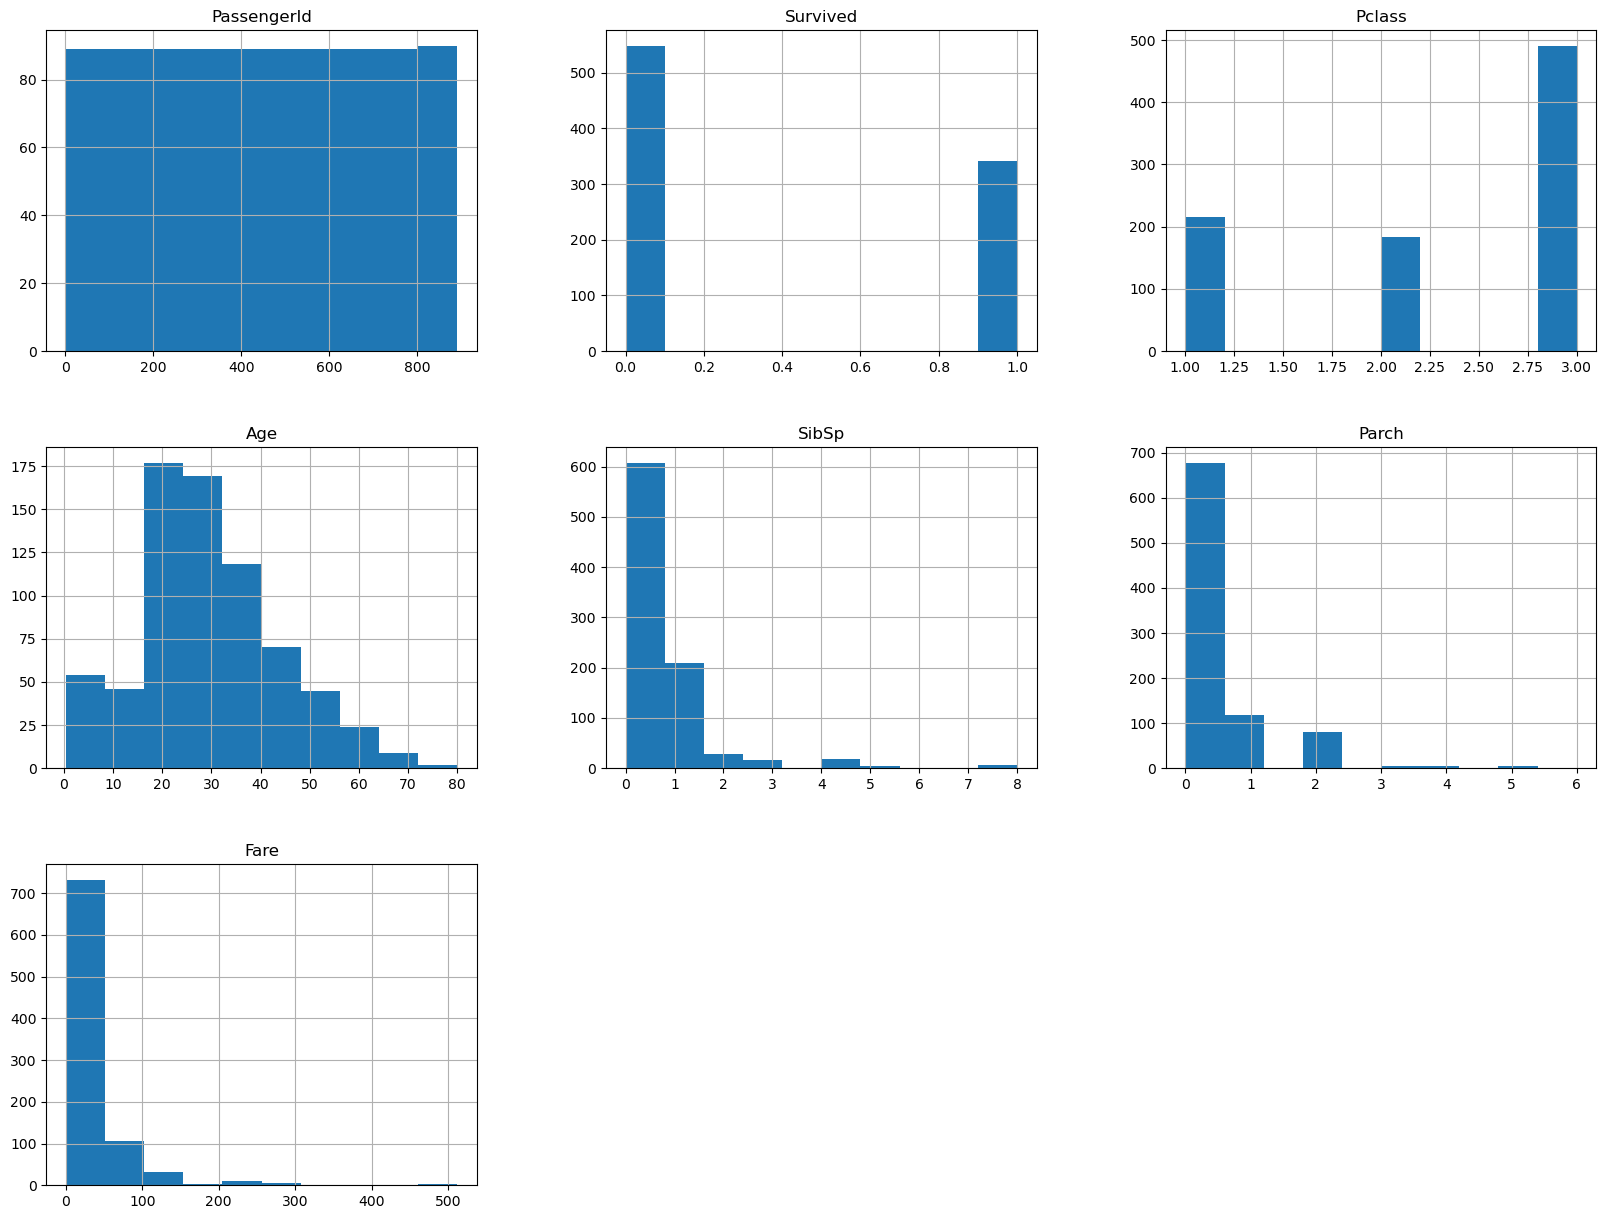

In [141]:
train_data.hist(figsize=(20,15))
plt.show()

### 数据预处理

####  数值转换流水线

处理数值属性("Age", "SibSp", "Parch", "Fare")

- 自定义转化器 :构建的`DataFrame转化器`以从数据帧中选择特定属性

In [142]:
from sklearn.base import BaseEstimator, TransformerMixin

In [143]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr_names):
        self.attr_names = attr_names
    def fit(self, X, y=None):
        return self     # nothing else to do
    def transform(self, X):
        return X[self.attr_names]

构建流水线

- 使用`Scikit-Learn`的`SimpleImputer`处理缺失值
- 使用`Scikit-Learn`的`Pipeline`类实现以正确的顺序执行数据转换

In [144]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [145]:
num_pipeline = Pipeline([
    ('select_num', DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ('imputer', SimpleImputer(strategy="median"))   # 使用中位数进行填充
])
# 处理数值列
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

#### 分类属性转换流水线

处理分类属性("Pclass", "Sex", "Embarked")

由于**Embarked**中有部分属性的值缺失

使用`MostFrequentImputer转化器`:将`出现频率最多`的作为填充数据，对空白数据进行填充

In [146]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

1. 读取频率最高属性值的方法

In [147]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [148]:
mostFre_data = [train_data[c].value_counts().index[0] for c in train_data]   # 取得所有列频率最高的属性的值
mostFre_data

[1,
 0,
 3,
 'Braund, Mr. Owen Harris',
 'male',
 24.0,
 0,
 0,
 '347082',
 8.05,
 'B96 B98',
 'S']

2. `pd.Series()`
    - Pandas是基于`Series`和`DataFrame`两种数据类型的。
    - `Series`：一个Series是一个一维的数据类型，其中每一个元素都有一个标签。类似于Numpy中元素带标签的数组，其中标签可以是数组或者是字符串

In [149]:
pd.Series(mostFre_data, index=train_data.columns)

PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                               24.0
SibSp                                0
Parch                                0
Ticket                          347082
Fare                              8.05
Cabin                          B96 B98
Embarked                             S
dtype: object

3.  `fillna()`  填充/替换缺失数据

构建流水线

- 为了解决属性之间的相似度的问题，我们采用`One-Hot 编码` 

In [150]:
from sklearn.preprocessing import OneHotEncoder

In [151]:
cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ('MF_imputer', MostFrequentImputer()),   # 使用最高频属性值进行填充
    ('test', OneHotEncoder(sparse=False))
])
# 处理分类列
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

#### 整合的数据预处理流水线

使用`Scikit-Learn`的`FeatureUnion`将多个转换器组合成一个新的对象，`FeatureUnion` 能和 `Pipeline` 组合使用。

In [152]:
from sklearn.pipeline import FeatureUnion

In [153]:
preprocess_pipeline = FeatureUnion(
                        transformer_list=[
                            ('num_pipeline', num_pipeline),
                            ('cat_pipeline', cat_pipeline),
                        ], n_jobs=-1)

In [154]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [155]:
y_train = train_data['Survived']    # 标签
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### 模型训练

#### 使用SVM分类器

 利用`Scikit-Learn`的`SVC()`函数支持向量机用于分类

In [156]:
from sklearn.svm import SVC

In [157]:
svm_clf_model = SVC(random_state=42, gamma="auto")
svm_clf_model.fit(X_train, y_train)

SVC(gamma='auto', random_state=42)

- 对测试集进行数据预处理

In [158]:
X_test = preprocess_pipeline.transform(test_data)

- 接下来，测试集进行预测

In [159]:
y_pred = svm_clf_model.predict(X_test)

- 使用交叉验证评估SVM分类器

In [160]:
from sklearn.model_selection import cross_val_score

In [161]:
svm_clf_model_scores = cross_val_score(estimator=svm_clf_model, 
                                       X=X_train,
                                       y=y_train,
                                       cv=20,
                                       scoring="accuracy",
                                      )
svm_clf_model_scores.mean()

0.7387878787878788

#### 使用随机森林模型分类器

利用`Scikit-Learn`的`RandomForestClassifier()`函数实现随机森林分类

In [162]:
from sklearn.ensemble import RandomForestClassifier

In [163]:
forest_clf_model = RandomForestClassifier(random_state=42, n_estimators=100)

In [164]:
forest_clf_model_scores = cross_val_score(estimator=forest_clf_model, 
                                          X=X_train,
                                          y=y_train,
                                          cv=20,
                                          scoring="accuracy"
                                         )
forest_clf_model_scores.mean()

0.8238383838383838

因此，随机森林模型分类器的表现要优于SVM分类器

### 方案可视化

In [165]:
import matplotlib.pyplot as plt

In [166]:
# 使用中文字体
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='../Fonts/SourceHanSerifSC-Medium.otf', size=12)

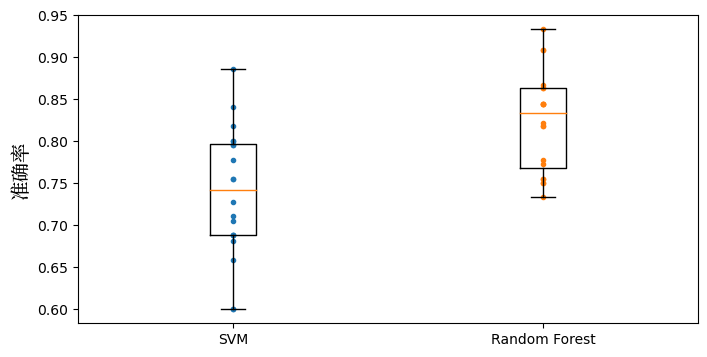

In [167]:
plt.figure(figsize=(8, 4))

plt.plot([1]*20, svm_clf_model_scores, ".")
plt.plot([2]*20, forest_clf_model_scores, ".")

plt.boxplot([svm_clf_model_scores, forest_clf_model_scores], labels=("SVM","Random Forest"))
plt.ylabel("准确率", fontsize=14, fontproperties=my_font)

plt.show()

### 进一步优化

1. 使用交叉验证和网格搜索微调模型，获取最佳的参数组合
2. 获取更多的特征工程：
    - 将**SibSp**和**Parch**用它们之和进行替代
    - 尝试去识别**name**与**Survived**属性相关的部分
3. 尝试将数值属性转换为分类属性：如不同年龄段的存活率大相径庭；独自旅行的只有30%的人存活...

以年龄段和存活率关系为例：

In [168]:
train_data['Age_Bucket'] = train_data["Age"] // 15 * 15
train_data[['Age_Bucket', 'Survived']].groupby(['Age_Bucket']).mean()

,Survived
Age_Bucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


以同行人数和存活率关系为例：

In [169]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


> create:Apotosome 07/07/21

> update:Apotosome 10/26/22